# Helper notebook for generating population samples with individuals in it
Get the 10% of the actual population as a representative sample

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from population_meta_data import Constants

In [2]:
#population class for generating population samples (individuals)
CONSTANTS = Constants.CONSTANTS
class PopulationSampleGenerator():
    def __init__(self, cast):
        self.cast = cast
        self.women_ratio = CONSTANTS['cast'][self.cast]['women_ratio']
        self.sample_size = CONSTANTS['cast'][self.cast]['sample_size']
        self.women_age_bins = CONSTANTS['cast'][self.cast]['women_age_bins']
        self.women_age_bin_prob = CONSTANTS['cast'][self.cast]['women_age_bin_prob']
        self.men_age_bins = CONSTANTS['cast'][self.cast]['men_age_bins']
        self.men_age_bin_prob = CONSTANTS['cast'][self.cast]['men_age_bin_prob']
        self.median_age = CONSTANTS['cast'][self.cast]['median_age']

    def simulateAge(self):
        #simulate women age first
        sample_size_women = int(round(self.sample_size * self.women_ratio, 0))
        probs = self.women_age_bin_prob / self.women_age_bin_prob.sum()
        bin_indices = np.random.choice(len(probs), size=sample_size_women, p=probs)
        women_samples = np.random.uniform(self.women_age_bins[bin_indices], self.women_age_bins[bin_indices + 1])

        #simulate men age
        sample_size_men = int(round(self.sample_size * (1-self.women_ratio), 0))
        probs = self.men_age_bin_prob / self.men_age_bin_prob.sum()
        bin_indices = np.random.choice(len(probs), size=sample_size_men, p=probs)
        men_samples = np.random.uniform(self.men_age_bins[bin_indices], self.men_age_bins[bin_indices + 1])

        df = pd.DataFrame({
            'idx': range(0, self.sample_size), 
            'age': np.concatenate(
                    [np.round(women_samples, 0).astype('int'),
                    np.round(men_samples, 0).astype('int')]
                    ), 
            'sex' :np.concatenate(
                    [np.zeros(int(round(self.sample_size * self.women_ratio, 0))).astype('int'),
                    np.ones(int(round(self.sample_size * (1-self.women_ratio)))).astype('int')]
                    )})
        
        return df

    def plotAge(self):
        df = self.simulateAge()
        # create plots for the age groups in cast 4
        men = df[df['sex'] == 1]['age']
        women = df[df['sex'] == 0]['age']
        df['age_group'] = pd.cut(df['age'], self.women_age_bins)

        age_pyramid = (
            df
            .groupby(['age_group', 'sex'])
            .size()
            .reset_index(name='count')
        )
        pyramid = age_pyramid.pivot(index='age_group', columns='sex', values='count').fillna(0)
        pyramid.columns = ['Women', 'Men']
        pyramid['Men'] = -pyramid['Men']
        pyramid = pyramid.iloc[::-1, ::-1]

        figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

        ax1.hist(women, bins=20, alpha=0.6, label='Women', color='salmon')
        ax1.axvline(self.median_age, color='k', linestyle='dashed', linewidth=1)
        ax1.hist(men, bins=20, alpha=0.6, label='Men', color='steelblue')
        ax1.legend()

        sns.barplot(
            x='Women', y=pyramid.index, data=pyramid.reset_index(), color='salmon', label='Women', order = pyramid.index

        )
        sns.barplot(
            x='Men', y=pyramid.index, data=pyramid.reset_index(), color='steelblue', label='Men', order = pyramid.index
        )
        plt.tight_layout()
        plt.savefig(f'{self.cast}cast_age_and_sex_plot.png')

        

/var/folders/41/f2g8g_gx5mxdj1zjg_yp7_c40000gn/T/ipykernel_8409/626341857.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['age_group', 'sex'])


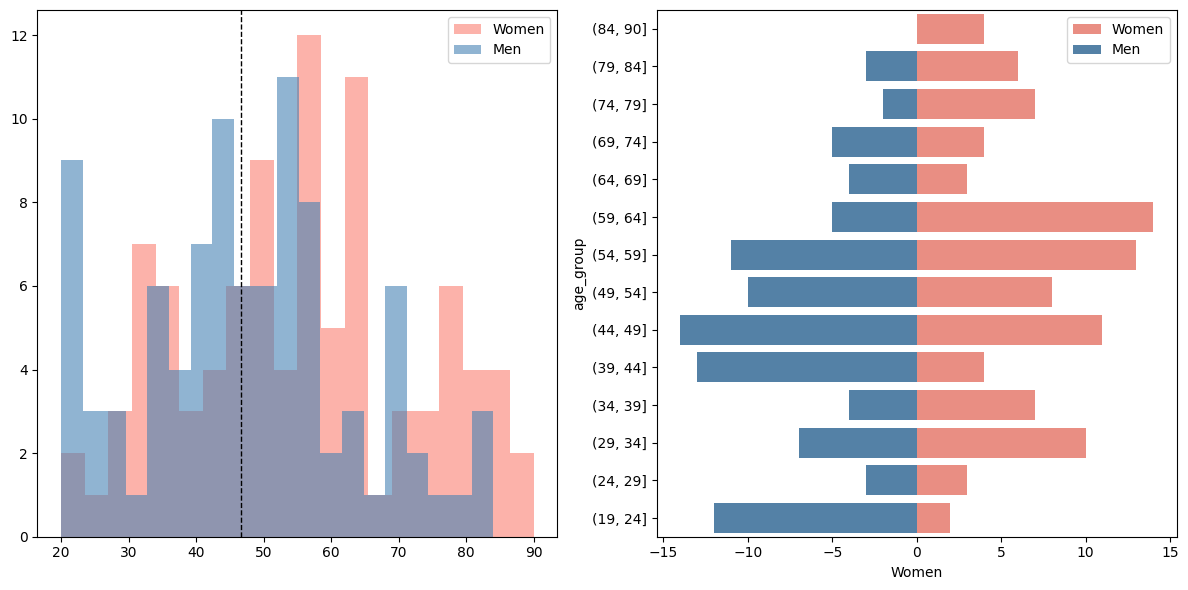

In [3]:
popsim = PopulationSampleGenerator("1st")
popsim.plotAge()